## Fitness Tracker Analysis - Part 1

### 1 - Overview

Inspired by the Quantified Self authoried by Mark Hoogendoorn and the availability of sample fitness data, and with Dave Ebbelaar's guidance, I wanted to explore machine learning models to classify: 

1) the type of movement, 
2) the number of repetitions of that movement, and 
3) the number of sets per workout. 

Such an use case would be helpful because I'm not a fan of writing down how many sets and reps I did for each workout. Instead, the classification algorithm can do all of that while I go by "feel" of exercising to near-failure, thereby making real progress in strength training, rather than arbitrarily exercising to a predetermined number of reps or sets.

### 2 - The Data

The sample data was recorded using the MetaMotionS, a wearable device that offers real-time and continuous monitoring of motion and environmental sensor data.

This data was collected by Dave Ebbelaar when tracking 5 participants as they performed various barbell exercises.

https://mbientlab.com/metamotions/

All the data is stored in the /data/raw/ folder as multiple .csv files. For each participant and exercise, two sets of data were collected:

| Accelerometer data (meters/second-squared) | Gyroscope data (degrees/seconds) |
| - | - |
| 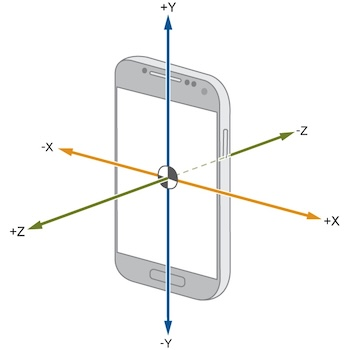 | 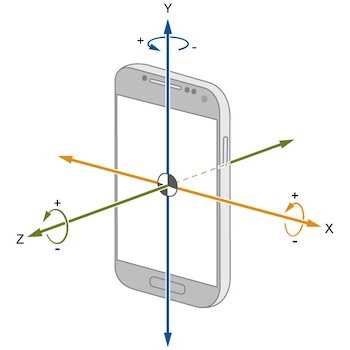 |

All the raw data will be read and marged into a single panda DataFrame with both accelerometer and gyroscope data.

In [1]:
# Import both pandas and glob libraries
import pandas as pd
from glob import glob

# Set the path to the data files
data_path = "../data/raw/*.csv"
files = glob(data_path)

# Read all files using a function and combine them into 2 sets
def read_data_from_files(files):

    acc_df = pd.DataFrame()
    gyr_df = pd.DataFrame()

    acc_set = 1
    gyr_set = 1

    # Loop through all the files in the directory
    for f in files:

        # Create new features from filename - participant, label, category
        participant = f.split("-")[0].replace(data_path.rstrip("*.csv"), "")
        label = f.split("-")[1]
        category = f.split("-")[2].rstrip("123").rstrip("_MetaWear_2019")

        df = pd.read_csv(f)

        df["participant"] = participant
        df["label"] = label
        df["category"] = category

        # Organize data into two datasets - Accelerometer and Gyroscope
        if "Accelerometer" in f:
            df["set"] = acc_set
            acc_set += 1
            acc_df = pd.concat([acc_df, df])

        if "Gyroscope" in f:
            df["set"] = gyr_set
            gyr_set += 1
            gyr_df = pd.concat([gyr_df, df])

    # Append each file to each corresponding dataset
    acc_df.index = pd.to_datetime(acc_df["epoch (ms)"], unit="ms")
    gyr_df.index = pd.to_datetime(gyr_df["epoch (ms)"], unit="ms")

    # Remove extra time-based columns (no longer needed)
    del acc_df["epoch (ms)"]
    del acc_df["time (01:00)"]
    del acc_df["elapsed (s)"]

    del gyr_df["epoch (ms)"]
    del gyr_df["time (01:00)"]
    del gyr_df["elapsed (s)"]

    # Return the combined datasets
    return acc_df, gyr_df

# Call the read_data_from_files() function
acc_df, gyr_df = read_data_from_files(files)

In [2]:
# Merge the two datasets into a single DataFrame
data_merged = pd.concat([acc_df.iloc[:, :3], gyr_df], axis=1)

data_merged.columns = [
    "acc_x",
    "acc_y",
    "acc_z",
    "gyr_x",
    "gyr_y",
    "gyr_z",
    "participant",
    "label",
    "category",
    "set",
]

Upon inspection of the merged dataset using the ```.head()``` and ```.info()``` functions, we immediately see a problem. The accelerometer and gyroscope data have been recorded at different timestamps. 

In [3]:
data_merged.info()
data_merged.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69677 entries, 2019-01-11 15:08:04.950000 to 2019-01-20 17:35:13.702000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        23578 non-null  float64
 1   acc_y        23578 non-null  float64
 2   acc_z        23578 non-null  float64
 3   gyr_x        47218 non-null  float64
 4   gyr_y        47218 non-null  float64
 5   gyr_z        47218 non-null  float64
 6   participant  47218 non-null  object 
 7   label        47218 non-null  object 
 8   category     47218 non-null  object 
 9   set          47218 non-null  float64
dtypes: float64(7), object(3)
memory usage: 5.8+ MB


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:04.950,NaN,NaN,NaN,-10.671,-1.524,5.976,B,bench,heavy,64.0
2019-01-11 15:08:04.990,NaN,NaN,NaN,-8.720,-2.073,3.171,B,bench,heavy,64.0
2019-01-11 15:08:05.030,NaN,NaN,NaN,0.488,-3.537,-4.146,B,bench,heavy,64.0
2019-01-11 15:08:05.070,NaN,NaN,NaN,0.244,-5.854,3.537,B,bench,heavy,64.0
2019-01-11 15:08:05.110,NaN,NaN,NaN,-0.915,0.061,-2.805,B,bench,heavy,64.0


To address the timestamp mismatch issue, we'll try resampling the data to 200ms while taking the mean of all numerical values except the ```set``` feature. This way, we should have both accelerometer and gyroscope data at each 200ms interval.  

In [4]:
sampling = {
    "acc_x": "mean",
    "acc_y": "mean",
    "acc_z": "mean",
    "gyr_x": "mean",
    "gyr_y": "mean",
    "gyr_z": "mean",
    "participant": "last",
    "label": "last",
    "category": "last",
    "set": "last",
}

data_merged[:1000].resample(rule="200ms").apply(sampling)


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:04.800,NaN,NaN,NaN,-9.69550,-1.7985,4.5735,B,bench,heavy,64.0
2019-01-11 15:08:05.000,NaN,NaN,NaN,-2.01220,-0.4270,-1.6218,B,bench,heavy,64.0
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.89040,2.4392,0.9388,B,bench,heavy,64.0
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.68260,-0.8904,2.1708,B,bench,heavy,64.0
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.56080,-0.2560,-1.4146,B,bench,heavy,64.0
...,...,...,...,...,...,...,...,...,...,...
2019-01-11 15:10:21.600,-0.174000,1.092667,-0.153333,-4.96360,-16.4026,21.9026,A,bench,heavy,72.0
2019-01-11 15:10:21.800,-0.219500,1.402500,-0.109000,-7.52440,18.6706,-22.6828,A,bench,heavy,72.0
2019-01-11 15:10:22.000,-0.192000,0.871667,-0.155667,2.60980,8.7070,-14.8658,A,bench,heavy,72.0


Now that the merge and resample worked, split the data by the day and apply this transformation to the rest of the dataframe.

In [5]:
# Split by day
days = [g for n, g in data_merged.groupby(pd.Grouper(freq="D"))]

# Apply sampling to each day for the rest of the dataset
data_resampled = pd.concat(
    [df.resample(rule="200ms").apply(sampling).dropna() for df in days]
)

# Column 'set' was found to be a float64 object upon inspection, convert to int
data_resampled["set"] = data_resampled["set"].astype("int")


Inspect the full resampled dataset to make sure there are no missing values for both accelerometer and gyroscope data at 200ms intervals. 

In [6]:
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


Save the resampled dataset in an interim folder:

In [7]:
data_resampled.to_pickle("../data/interim/01_data_processed.pkl")


### 3 - Exploratory Analysis and Visualization

Create visualizations to better understand the accelerometer and gyroscope data before running classification models. Exploratory analysis helps to determine what type of feature engineering or scaling is needed. 

The plots are saved in the ../../reports/figures/ folder.

The file naming convention is: '{label}-{participant}.png'

First, import the plotting libraries:

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

import os
import sys

sys.path.append("../")
import src.visualization.visualize as vis

To make the plots look better, adjust the plotting style and settings:

In [9]:
mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100

In [10]:
# Load the data from the pickle file
df = pd.read_pickle("../data/interim/01_data_processed.pkl")


#### 3.1 - Examine a Single Feature

Plot a single column from a single set and inspect one of the accelerometer features:

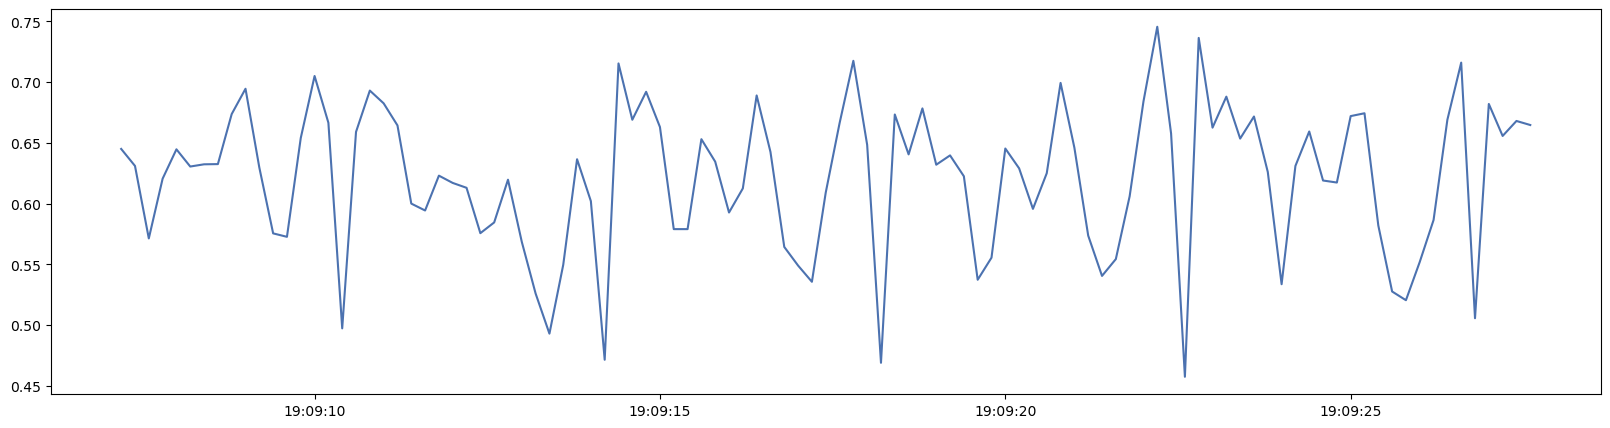

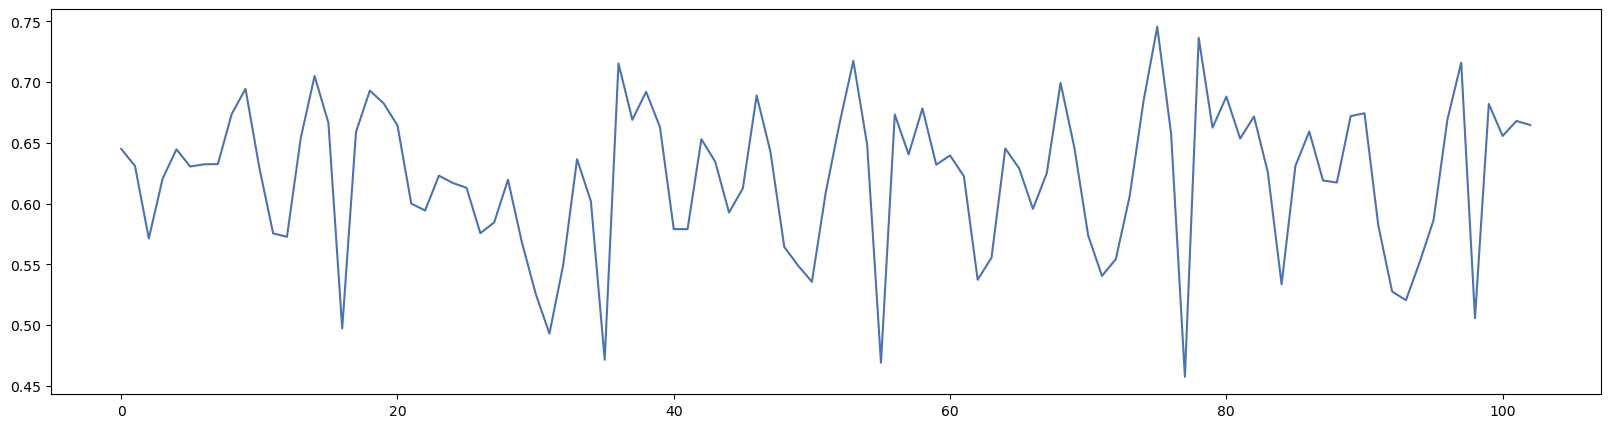

In [11]:
# Select a single subset
set_df = df[df["set"] == 1]

# Plot y-values over the duration of this set
plt.plot(set_df["acc_y"])
plt.show()

# Plot y-values over the number of samples in this set
plt.plot(set_df["acc_y"].reset_index(drop=True))
plt.show()

From the y-axis of the accelerometer, there seems to be a signal of 4 or 5 sets. However, there is a lot of "noise" that will need to be smoothed out before training the classification models.

#### 3.2 - Examine Exercise Patterns

Next, plot all data for each exercise:

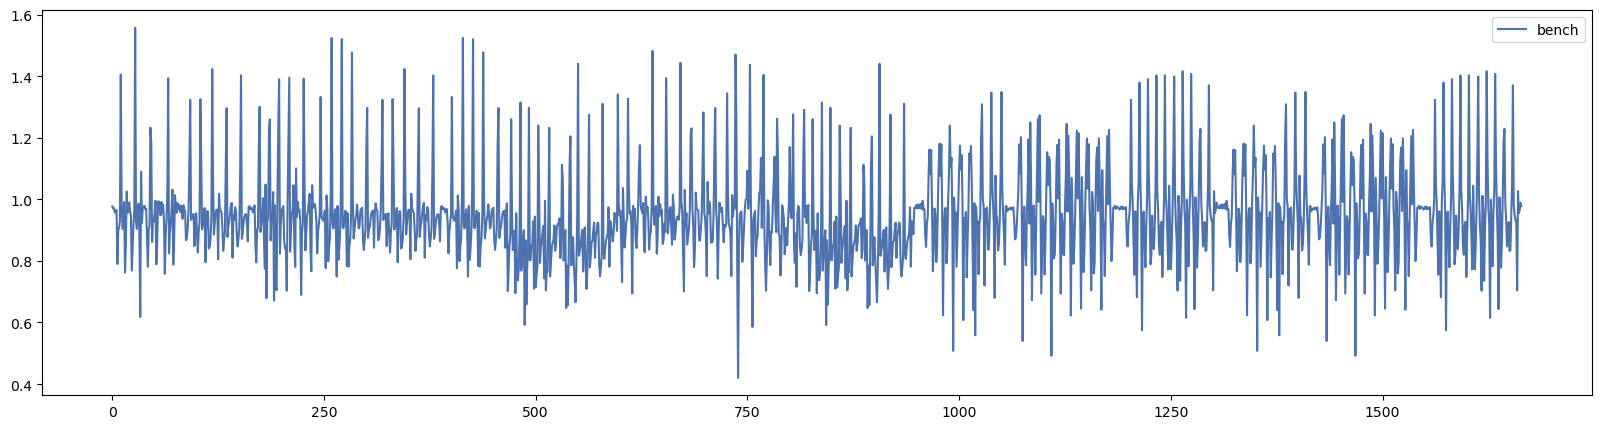

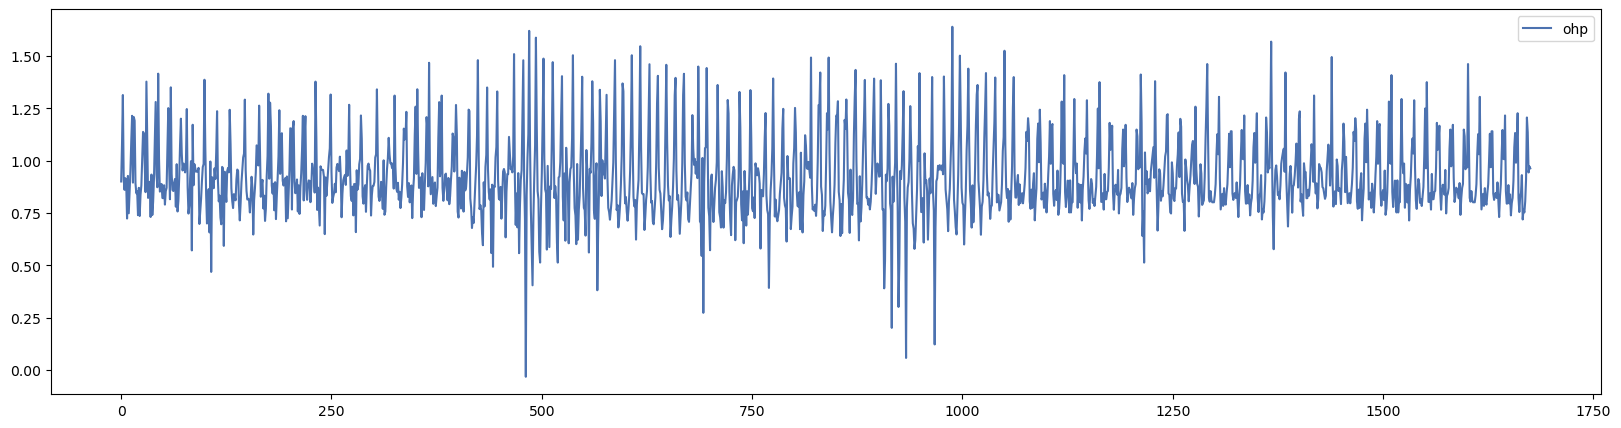

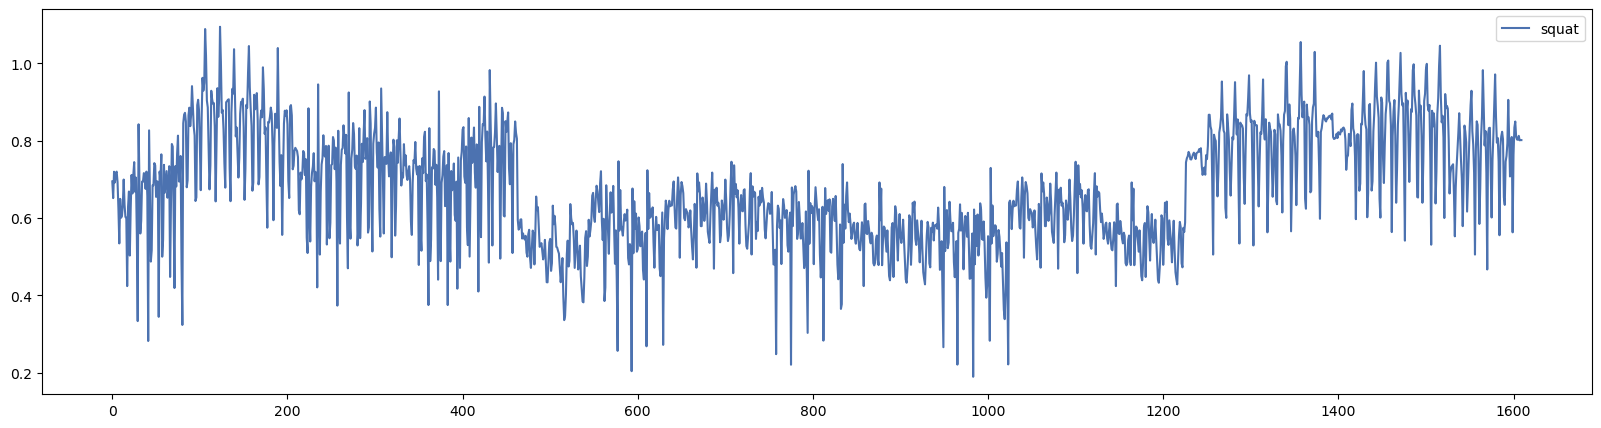

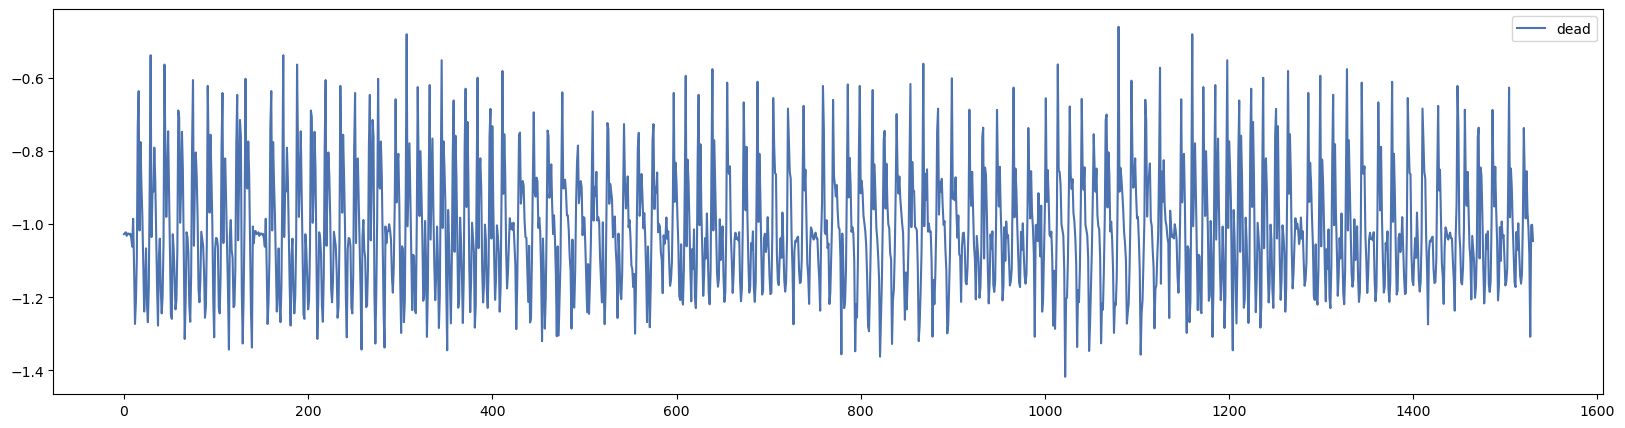

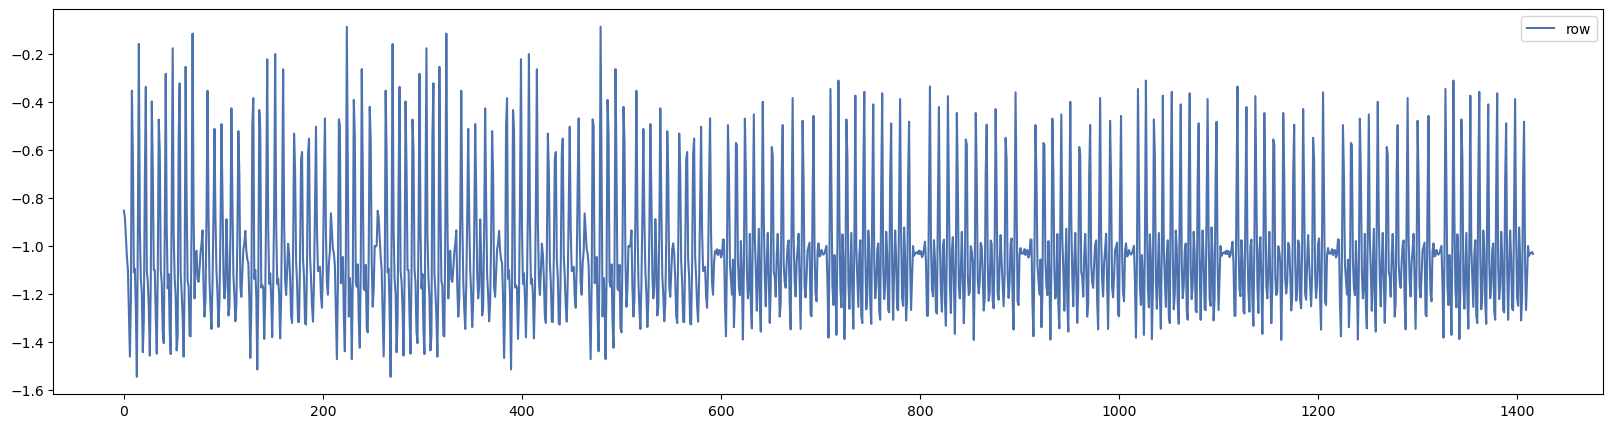

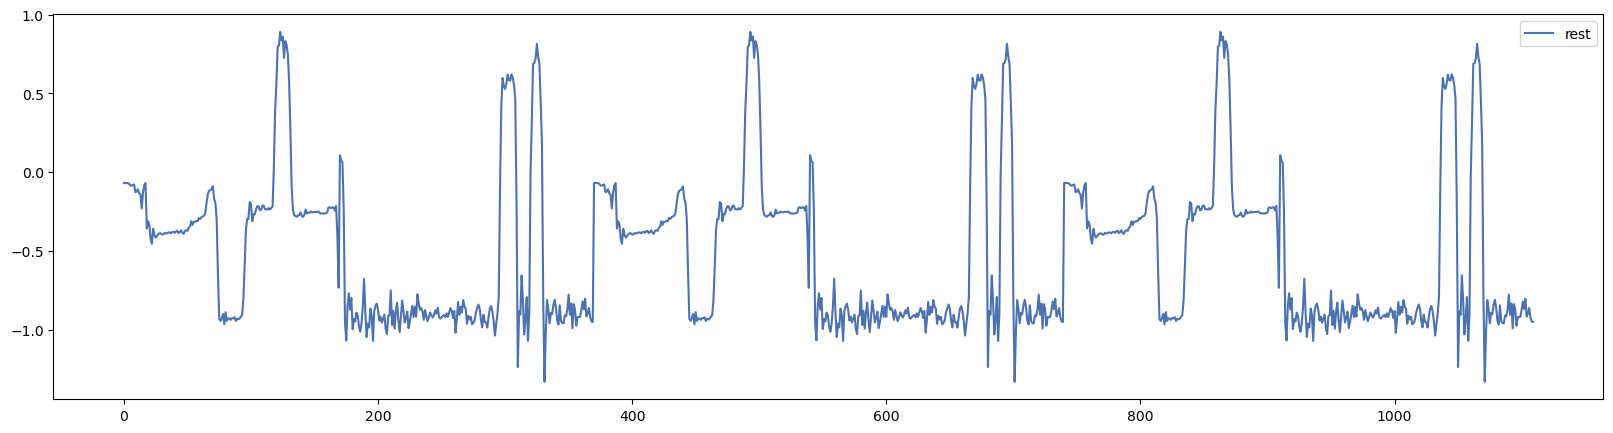

In [12]:
vis.plot_exercise_data(df, "acc_y")

While there are clear patterns in each exercise over the entire dataset, it would be useful to plot a small portion of each exercise to make the patterns more clearer:

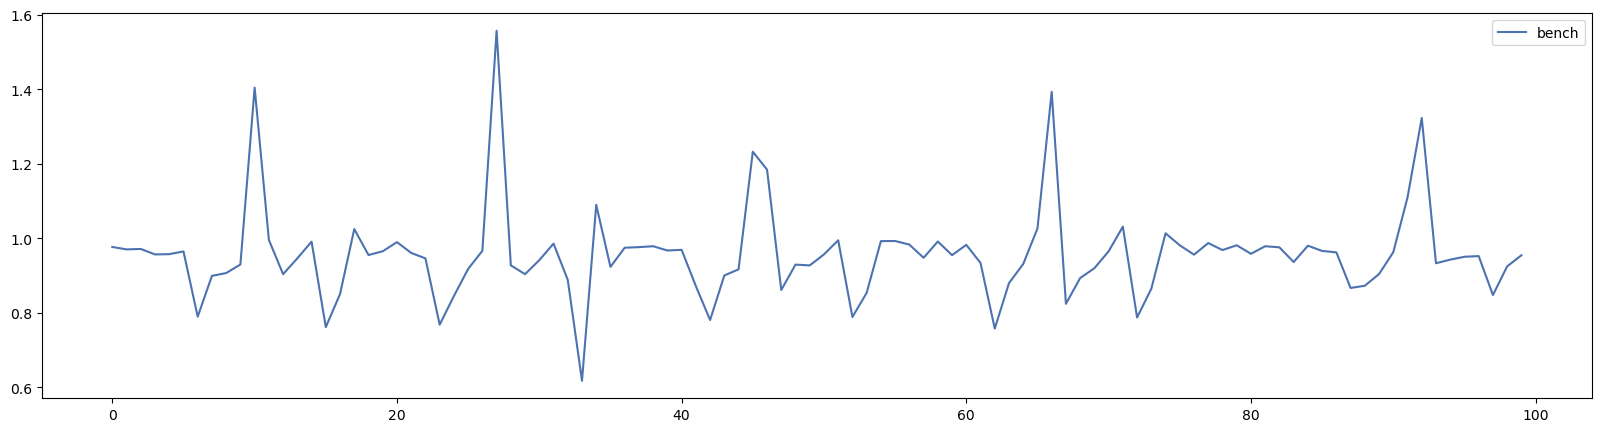

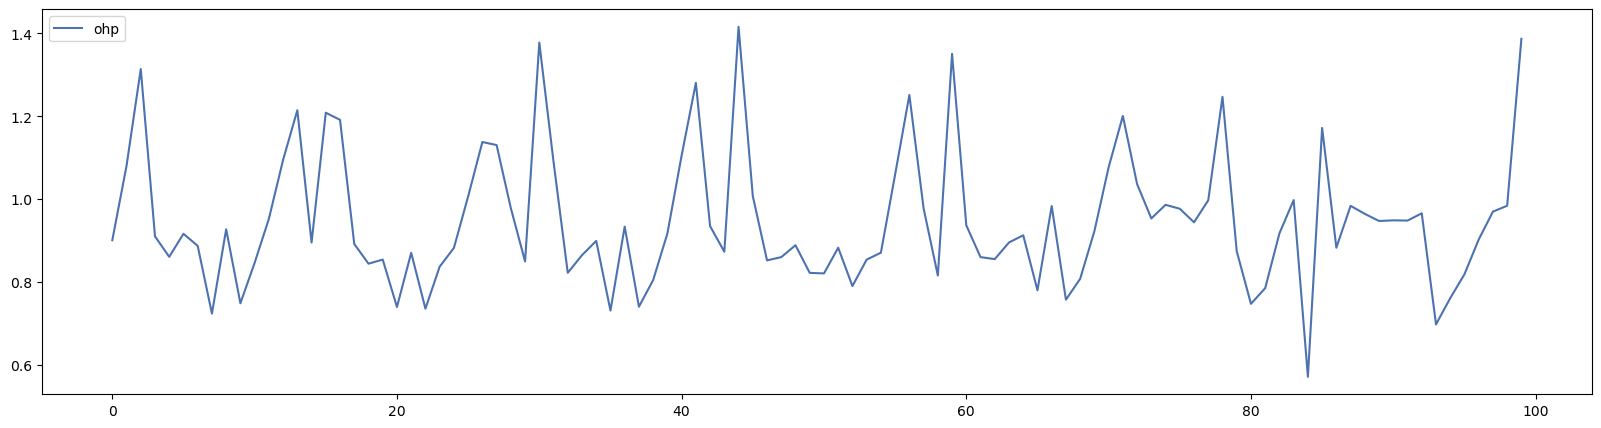

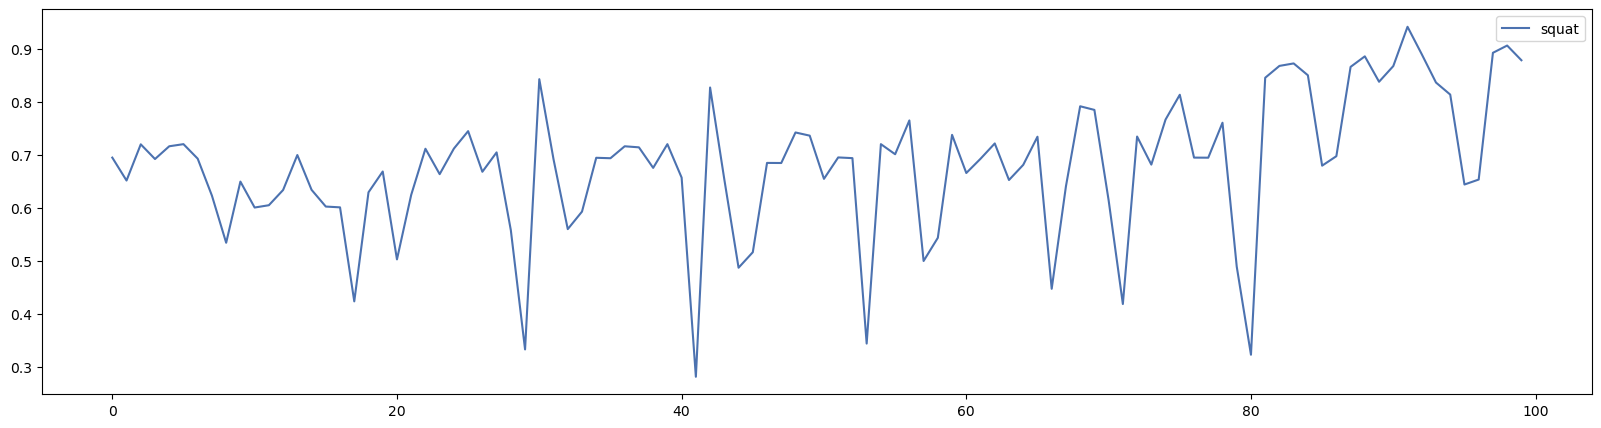

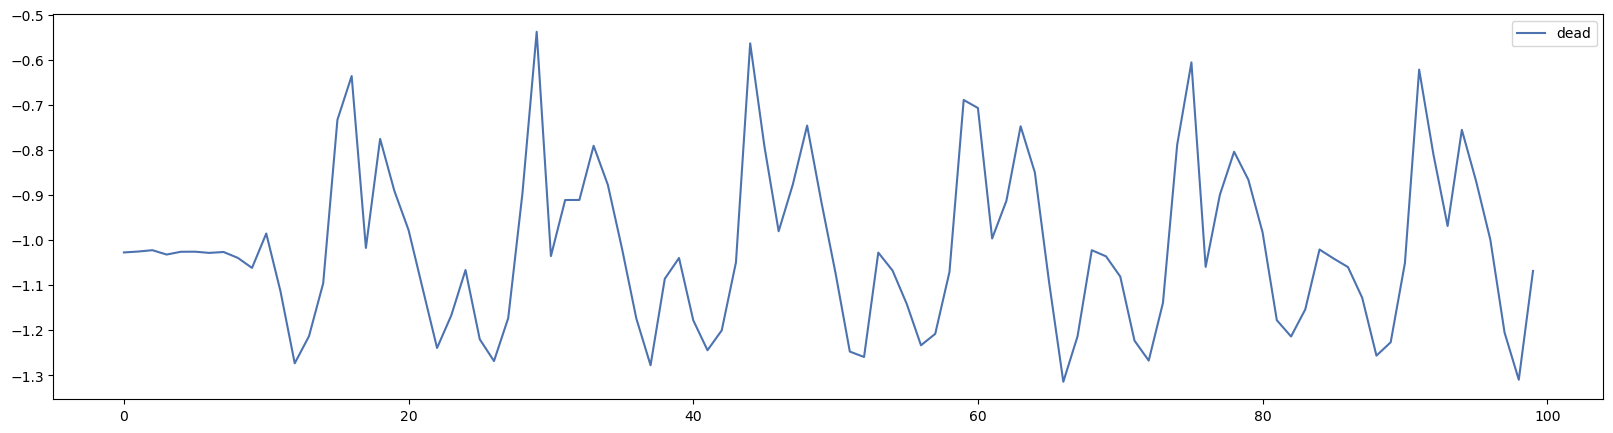

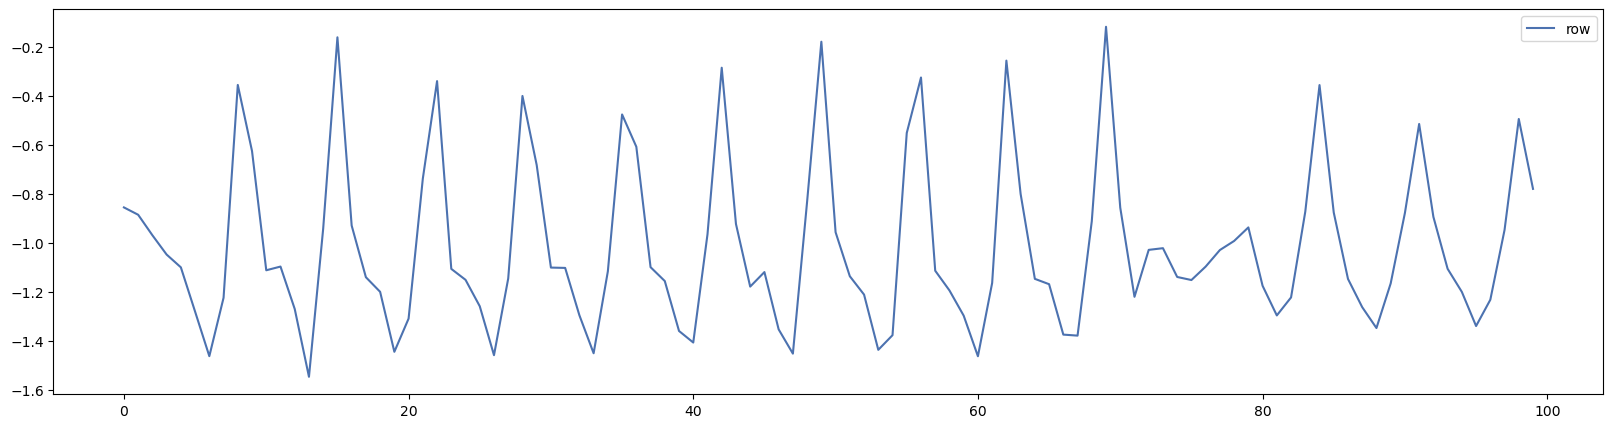

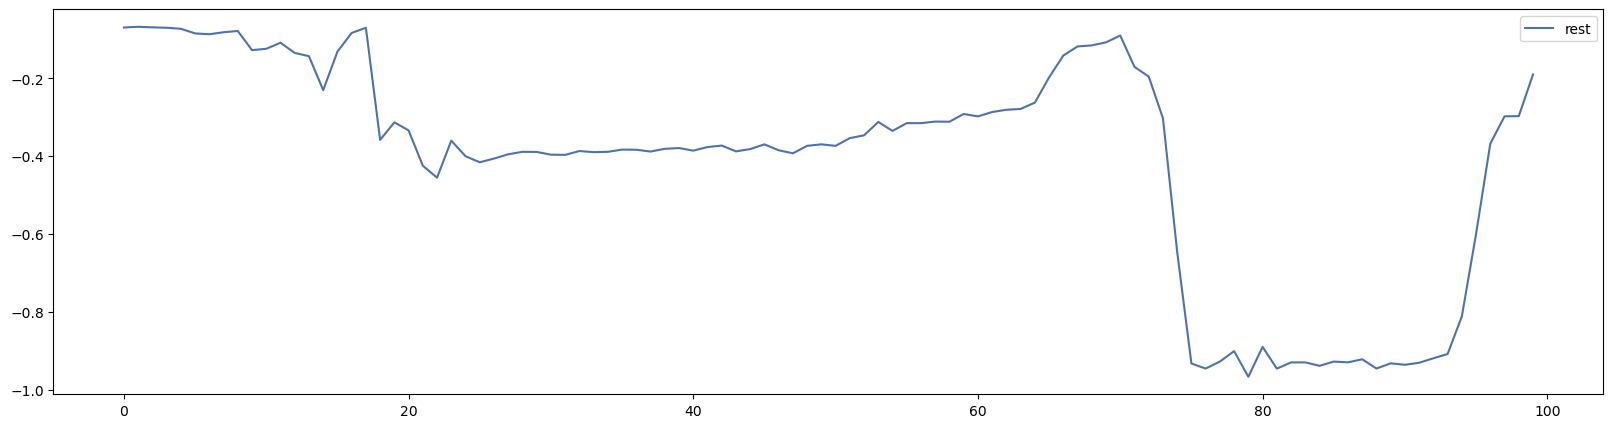

In [13]:
# Plot only the first 100 samples for each exercise
vis.plot_exercise_sample(df, "acc_y")

#### 3.3 - Examine Medium vs. Heavy Sets

Now we want to examine the ```categories``` feature:

In [14]:
df["category"].unique()

array(['heavy', 'medium', 'sitting', 'standing'], dtype=object)

For each set, we have two categories worth exploring: heavy and medium. We want to visualize comparisions between medium and heavy sets.

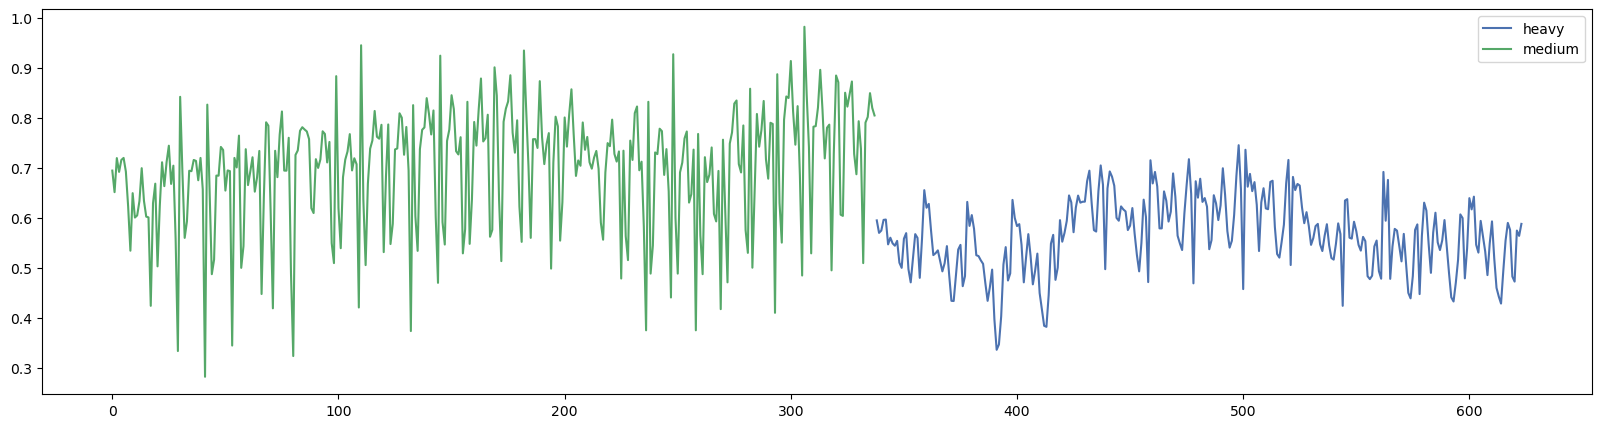

In [15]:
# Stacked queries to pull squat data for participant A
# Add reset_index to make sure the index is continuous (No. of samples)
category_df = df.query("label == 'squat'").query("participant == 'A'").reset_index()

# Group by category (heavy vs. medium) and plot the y-values
vis.plot_category_data(category_df, "acc_y")

There is a clear difference between medium and heavy sets, with faster accleration on the y-axis for medium sets and slower acceleration on the heavy sets.

#### 3.4 - Examine Exercise Patterns Among Participants

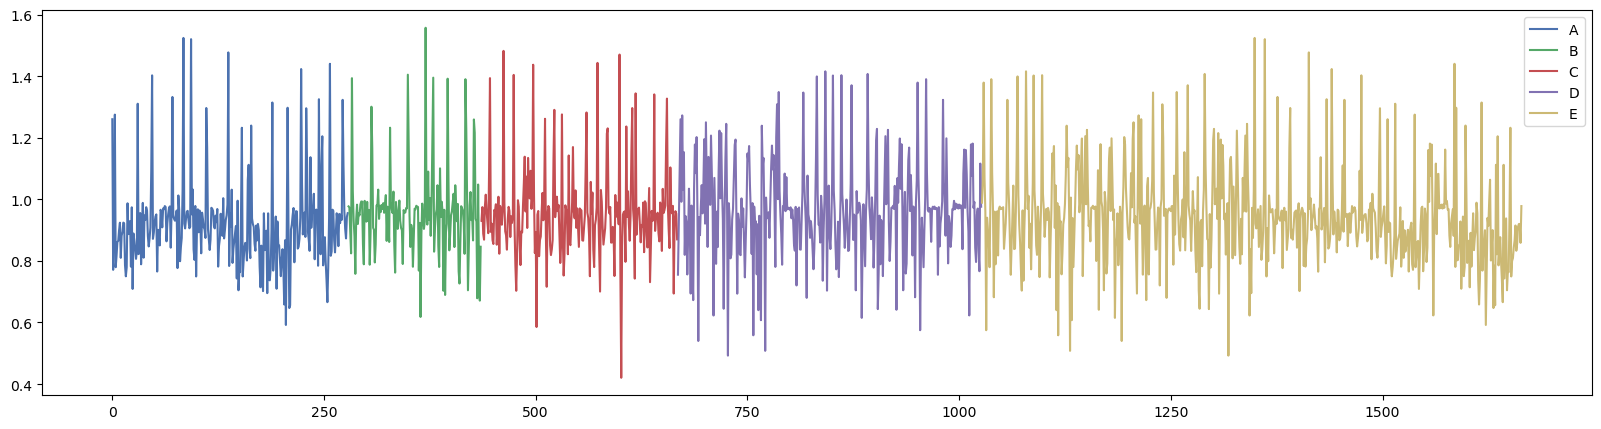

In [16]:
# Pull bench data for all participants (all categories)
participant_df = df.query("label == 'bench'").sort_values("participant").reset_index()

# Group by participant and plot the y-values for benching
vis.plot_participant_data(participant_df, "acc_y")

Exercise patterns among different participants seem similar for bench press and other excercises, so the classification algorithm should be able to generalize to unseen participants without engineering features based on differences between participants.

#### 3.5 - Plot All Accelerometer Variables In the Same Graph

Examine all accelerometer features ```acc_x```, ```acc_y```, and ```acc_z``` in the same graph.

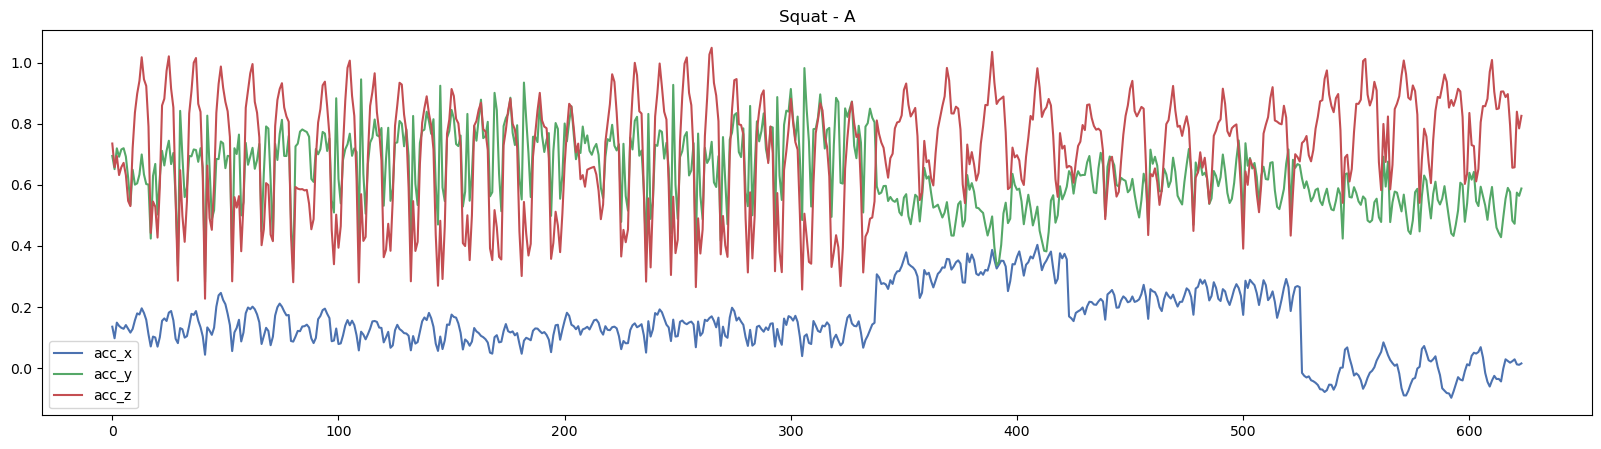

In [17]:
label = "squat"
participant = "A"
all_axis_df = (
    df.query(f"label == '{label}'")
    .query(f"participant == '{participant}'")
    .reset_index()
)

vis.plot_all_axis(all_axis_df, "acc_x", "acc_y", "acc_z", label, participant)


#### 3.6 - Plot All Combinations for Both Accelerometer and Gyroscope Sensors

For each exercise type and participant, plot accelerometer and gyroscope data, and save each plot to file in the `../reports/figures/` folder.

**Warning: Running this cell will create a large number of plots.**

In [18]:
labels = df["label"].unique()
participants = df["participant"].unique()

# Loop through all combinations of labels and participants
filepath = "../reports/figures/"
vis.create_combined_plots(df, labels, participants, filepath)
            
print("All plots have been saved to the ../reports/figures/ folder.")


All plots have been saved to the ../reports/figures/ folder.


## To be continued...

**To handle outliers and feature engineering, continue with Part 2 of this notebook here:**

`/notebooks/nk-fitness-tracker-feature-engineering-2.ipynb`